In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras

import opendatasets as od

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Dense, MaxPooling2D,Flatten,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger,TensorBoard,EarlyStopping,ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [ ]:
od.download("https://www.kaggle.com/datasets/deadskull7/fer2013")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tahakoleilat
Your Kaggle Key: ··········


100%|██████████| 96.6M/96.6M [00:00<00:00, 109MB/s]


In [3]:
od.download("https://www.kaggle.com/datasets/subhaditya/fer2013plus")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tahakoleilat
Your Kaggle Key: ··········


100%|██████████| 132M/132M [00:05<00:00, 23.7MB/s]


In [5]:
emotion = []
instances = []
print("Training images: ")
for expression in os.listdir('/content/fer2013plus/fer2013plus/fer2013/train/'):
    print(str(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/train/' + expression))) + " " + expression + " images")
    emotion.append(expression)
    instances.append(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/train/' + expression)))

Training images: 
2466 anger images
652 fear images
3562 surprise images
165 contempt images
191 disgust images
7528 happiness images
10308 neutral images
3514 sadness images


<BarContainer object of 8 artists>

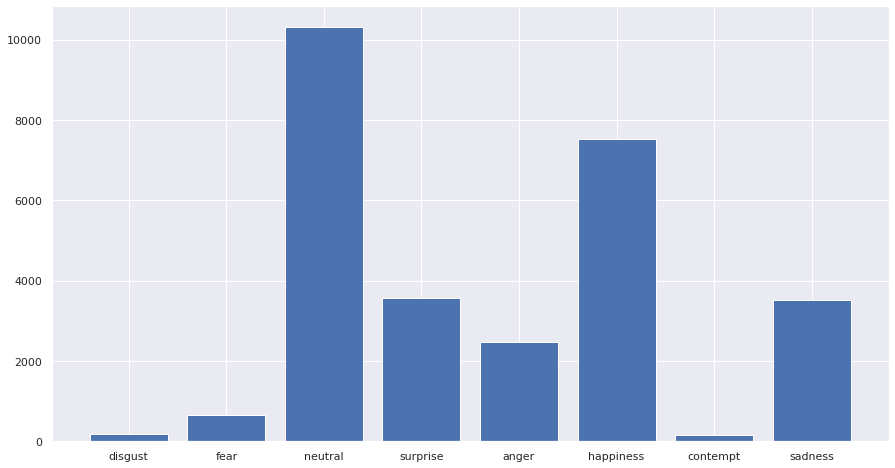

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(emotion,instances)

In [ ]:
emotion2 = []
instances2 = []
print("Testing images: ")
for expression in os.listdir('/content/fer2013plus/fer2013plus/fer2013/test/'):
    print(str(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/test/' + expression))) + " " + expression + " images")
    emotion2.append(expression)
    instances2.append(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/test/' + expression)))

Testing images: 
57 disgust images
167 fear images
2597 neutral images
900 surprise images
644 anger images
1827 happiness images
51 contempt images
856 sadness images


<BarContainer object of 8 artists>

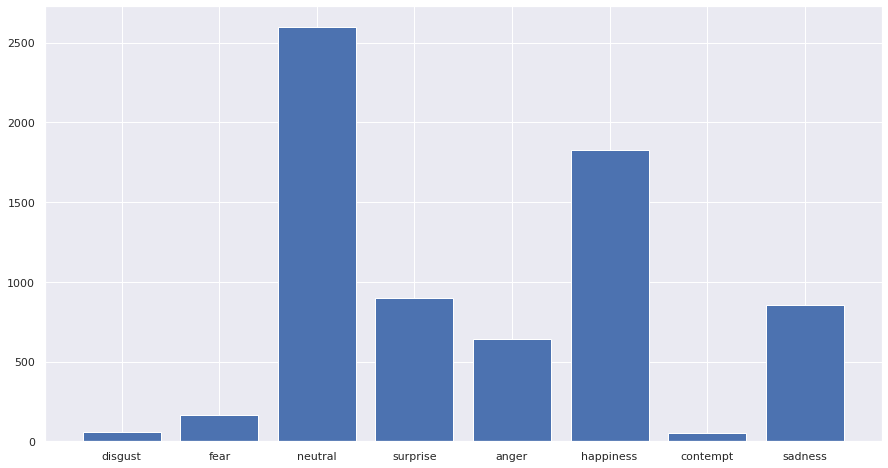

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(emotion2,instances2)

In [4]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   validation_split = 0.2, rotation_range=2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

In [6]:
valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,validation_split=0.2)

In [7]:
train_dataset3  = train_datagen.flow_from_directory(directory = '/content/fer2013plus/fer2013plus/fer2013/train',
                                                   class_mode = 'categorical',
                                                   color_mode="rgb",
                                                   subset = 'training',
                                                     target_size = (128,128),
                                                   classes={'anger': 0,'disgust': 1,'fear': 2,'happiness': 3,'neutral': 4,'sadness': 5,
                                                             'surprise': 6})
valid_dataset3 = valid_datagen.flow_from_directory(directory = '/content/fer2013plus/fer2013plus/fer2013/train',
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  color_mode="rgb",
                                                    target_size = (128,128),
                                                  classes={'anger': 0,'disgust': 1,'fear': 2,'happiness': 3,'neutral': 4,'sadness': 5,
                                                             'surprise': 6})

Found 22580 images belonging to 7 classes.
Found 5641 images belonging to 7 classes.


In [8]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_dataset2 = test_datagen.flow_from_directory(directory = '/content/fer2013plus/fer2013plus/fer2013/test',
                                                  class_mode = 'categorical',
                                                  color_mode="rgb",
                                                    target_size = (128,128),
                                                 classes={'anger': 0,'disgust': 1,'fear': 2,'happiness': 3,'neutral': 4,'sadness': 5,
                                                             'surprise': 6},shuffle=False)

Found 7048 images belonging to 7 classes.


In [9]:
training_set = train_dataset3
valid_set =  valid_dataset3
test_set = test_dataset2

In [10]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
import numpy as np 
import pandas as pd


import seaborn as sn
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def create_model(resnet, dense_nodes, drop, activation):
    return Sequential([
        resnet,
        Flatten(),
        Dense(256,kernel_initializer='he_uniform'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(7,activation='softmax')
    ])
def compile_and_train_model(model, epochs, lr):
   checkpoint_filepath = '/tmp/checkpointNew'
   earlyStopping = tf.keras.callbacks.EarlyStopping(
        patience=3,
        monitor="val_accuracy",
        verbose=1,)
   model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
       filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq="epoch")
   lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-10)
   adam = keras.optimizers.Adam(learning_rate=lr)
   METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
   model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)
   history = model.fit(training_set, validation_data = valid_set,validation_steps = 100, batch_size = 512, steps_per_epoch= 200,  epochs = epochs,
                        callbacks=[model_checkpoint_callback,earlyStopping,lrd])
   return history
def evaluate_model(model, history, test):
    print("Accuracy of our model on testing data : " , model.evaluate(test_set)[1]*100 , "%")
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
    ax1.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    ax2.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(history.history['auc']) + 1), history.history['auc'])
    ax3.plot(range(1, len(history.history['val_auc']) + 1), history.history['val_auc'])
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(history.history['precision']) + 1), history.history['precision'])
    ax4.plot(range(1, len(history.history['val_precision']) + 1), history.history['val_precision'])
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(history.history['recall']) + 1), history.history['recall'])
    ax5.plot(range(1, len(history.history['val_recall']) + 1), history.history['val_recall'])
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])
    plt.show()
def performance_metrics(model, test_set):
    y_pred = model.predict(test_set)
    y_result = []
    for p in y_pred:
        y_result.append(np.argmax(p))
    
    y_actual = []
    for i in range(len(test_set)):
        for p in test_set[i][1]:
            y_actual.append(np.argmax(p))
    
    print(classification_report(y_actual, y_result))
    
    cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

    plt.figure(figsize = (10, 8))
    sn.heatmap(cm, annot = True, fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
def test_resnet(resnet, dense_nodes, drop, activation, epochs, lr):
    model = create_model(resnet50, dense_nodes, drop, activation)
    model.summary()
    
    history = compile_and_train_model(model, epochs, lr)
    
    evaluate_model(model, history, test_set)
    
    performance_metrics(model, test_set)
    return model


94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0 

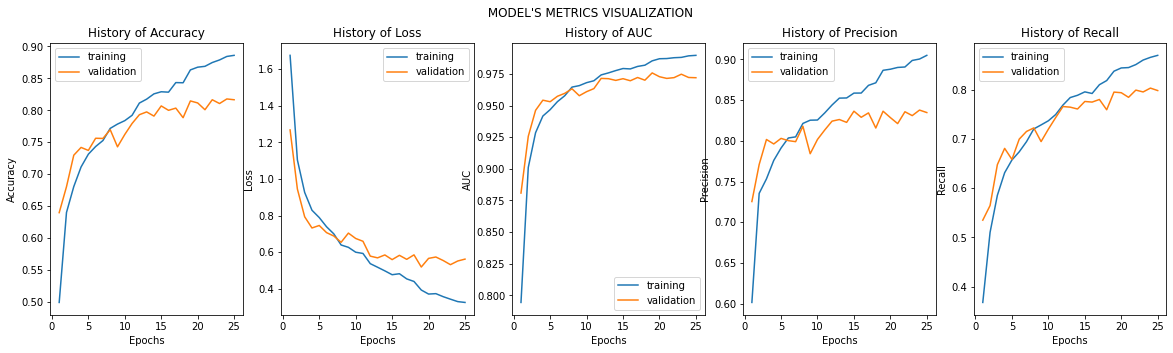

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       644
           1       0.79      0.33      0.47        57
           2       0.63      0.52      0.57       167
           3       0.91      0.90      0.91      1827
           4       0.82      0.89      0.85      2597
           5       0.70      0.59      0.64       856
           6       0.83      0.83      0.83       900

    accuracy                           0.82      7048
   macro avg       0.78      0.69      0.72      7048
weighted avg       0.82      0.82      0.82      7048



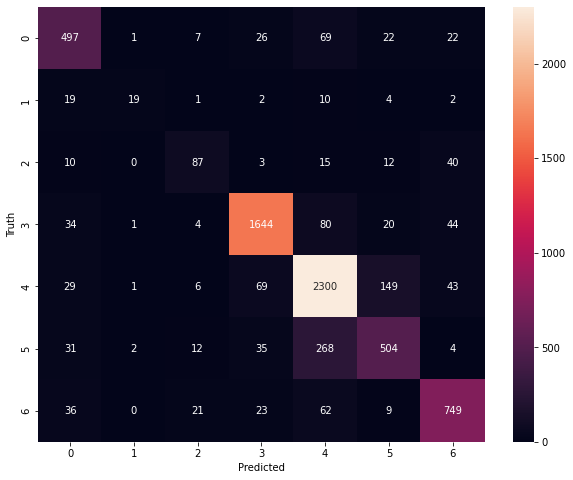

In [15]:
resnet50 = tf.keras.applications.resnet.ResNet50(include_top = False, input_shape = (128, 128, 3), weights = 'imagenet', pooling = "Max")
for layer in resnet50.layers:
    layer.trainable=True
dense_nodes = 256
drop = 0.4
activation = 'softmax'
epochs = 25
lr = 0.0001

model = test_resnet(resnet50, dense_nodes, drop, activation, epochs, lr)

In [11]:
from keras.models import load_model

model.save('model_weights_new_ferplus.h5')

In [12]:
model.load_weights("model_weights_new_ferplus.h5")

In [17]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [13]:
x_test=np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test=np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(x_test.shape)
print(y_test.shape)

(7048, 128, 128, 3)
(7048, 7)
